In [1]:
import aif360.datasets
creditg = aif360.datasets.GermanDataset()

/home/hirzel/python3.6venv/lib/python3.6/site-packages/aif360/datasets/standard_dataset.py:121: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  priv = np.logical_or.reduce(np.equal.outer(vals, df[attr]))


In [2]:
import pandas as pd
train_ds, test_ds = creditg.split([0.7], shuffle=True, seed=42)
def to_dataframes(aif360_ds):
    X = pd.DataFrame(aif360_ds.features, columns=aif360_ds.feature_names)
    y = pd.Series(aif360_ds.labels.ravel(), name=aif360_ds.label_names[0])
    return X, y
train_X, train_y = to_dataframes(train_ds)
test_X, test_y = to_dataframes(test_ds)

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import LinearSVC as SVM
from lale.lib.lale import NoOp
import lale.helpers
lale.helpers.wrap_imported_operators()

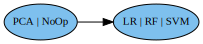

In [4]:
planned_orig = (PCA | NoOp) >> (LR | RF | SVM)
lale.helpers.to_graphviz(planned_orig)

100%|██████████| 50/50 [00:44<00:00,  1.52it/s, best loss: -0.7399398407982098]


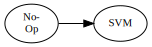

In [5]:
from lale.lib.lale.hyperopt_classifier import HyperoptClassifier
import logging
lale.lib.lale.hyperopt_classifier.logger.setLevel(logging.ERROR)
optimizer = HyperoptClassifier(planned_orig, cv=3, max_evals=50)
trained_orig = optimizer.fit(train_X, train_y)
lale.helpers.to_graphviz(trained_orig)

In [6]:
from sklearn.metrics import accuracy_score
predictions = trained_orig.predict(test_X)
print(f'accuracy {accuracy_score(test_y, predictions):.1%}')

accuracy 76.3%


See also results for credit-g dataset at OpenML: https://www.openml.org/d/31

In [7]:
protected_attr = 'sex'
unpr_groups = [{protected_attr: 0.0}]
priv_groups = [{protected_attr: 1.0}]

In [8]:
import aif360.metrics
def evaluate(model, dataset):
    X, y = to_dataframes(dataset)
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    dataset_pred = dataset.copy()
    dataset_pred.labels = predictions
    fairness_metrics = aif360.metrics.BinaryLabelDatasetMetric(
        dataset_pred, unpr_groups, priv_groups)
    fairness = fairness_metrics.disparate_impact()
    return {'accuracy': accuracy, 'fairness': fairness}

In [9]:
evaluate(trained_orig, test_ds)

{'accuracy': 0.7633333333333333, 'fairness': 0.7081585081585081}

In [10]:
import hyperopt
import lale.search.op2hp
def search(planned, dataset, max_evals):
    train_ds, test_ds = dataset.split([0.5], shuffle=True, seed=42)
    train_X, train_y = to_dataframes(train_ds)
    def point_to_trained(search_point):
        trainable = lale.helpers.create_instance_from_hyperopt_search_space(
            planned, search_point)
        trained = trainable.fit(train_X, train_y)
        return trained
    def objective(search_point):
        try:
            trained = point_to_trained(search_point)
            metrics = evaluate(trained, test_ds)
            if metrics['fairness'] < 0.9:
                loss = 1.0
            else:
                loss = 1.0 - metrics['accuracy']
        except BaseException:
            loss = 1.0
        assert 0 <= loss <= 1
        return {'loss': loss, 'status': hyperopt.STATUS_OK}
    search_space = lale.search.op2hp.hyperopt_search_space(planned)
    trials = hyperopt.Trials()
    hyperopt.fmin(
        objective, search_space, hyperopt.tpe.suggest, max_evals, trials)
    best_point = hyperopt.space_eval(search_space, trials.argmin)
    return point_to_trained(best_point)

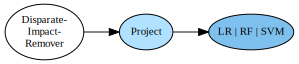

In [11]:
from lale.lib.aif360 import DisparateImpactRemover
from lale.lib.lale import Project
dimr = DisparateImpactRemover(sensitive_attribute=protected_attr)
proj = Project(columns=[i for i, name in enumerate(creditg.feature_names)
                        if name != protected_attr])
planned_fairer = dimr >> proj >> (LR | RF | SVM)
lale.helpers.to_graphviz(planned_fairer)

100%|█████████████████████████| 50/50 [00:50<00:00,  1.10s/it, best loss: 0.24]
{'accuracy': 0.7366666666666667, 'fairness': 0.9046153846153846}


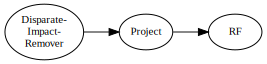

In [12]:
trained_fairer = search(planned_fairer, train_ds, 50)
print(evaluate(trained_fairer, test_ds))
lale.helpers.to_graphviz(trained_fairer)